# 머신러닝   
       
10주 1강: 로지스틱 회귀

이번 강의는 로지스틱 회귀에 대해서 생각해 보겠습니다

## 분류 문제를 위한 평가 지표들
### 혼동행렬
* 분류 문제에 대해서는 기본적으로 혼동행렬을 통한 지표를 많이 사용합니다. 
* 혼동행렬은 아래와 같이 만듭니다.

|   | Pred 1 | Pred 0 |
|---|--------|--------|
| **1** | TP     | FN     |
| **0** | FP     | TN     |


In [1]:
from sklearn.metrics import confusion_matrix
# sklearn.metrics에 이미 있습니다.
y_true = [1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]
confusion_matrix(y_true, y_pred)

array([[2, 0],
       [1, 3]])

In [2]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
(tn, fp, fn, tp) # 표와는 순서가 다르다는 것을 유의해주세요. 

(np.int64(2), np.int64(0), np.int64(1), np.int64(3))

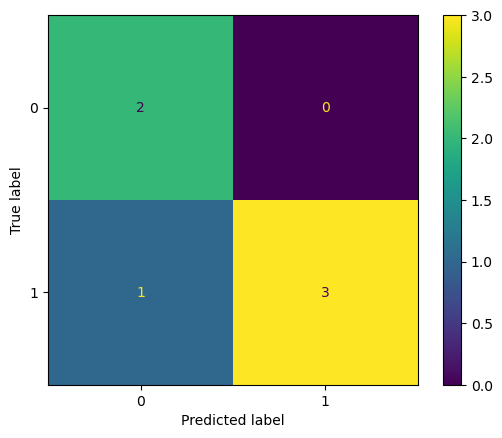

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()

### 정확도(Accuracy)
* 전체 데이터 개수 대비 정답을 맞춘 개수입니다

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$


In [4]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred = np.array([0, 1, 1, 0])
y_true = np.array([0, 1, 0, 0])
sum(y_true == y_pred) / len(y_true)

np.float64(0.75)

In [5]:
y_true == y_pred

array([ True,  True, False,  True])

In [6]:
accuracy_score(y_true, y_pred)

0.75

### 정밀도, 민감도, F1
* 불균일한 데이터에서 체크할 필요가 있습니다.
  * 예시: 9:1 데이터에서, 모두 True만 고르면 정확도가 0.9가 됩니다(!!)
* 이 문제를 해결하기 위해서는? 다른 지표가 필요!

|   | Pred 1 | Pred 0 |
|---|--------|--------|
| **1** | **TP**     | FN     |
| **0** | FP     | TN     |

* 정밀도 (Precision): 모델이 1이라 예측했을 때 얼마나 잘 맞추나
  * $Precision = \frac{TP}{TP+FP}$

* 민감도 (Recall): 실제 1인 값인 데이터를 모델이 얼마나 1이라고 잘 예측했나
  * $Recall = \frac{TP}{TP+FN}$
  
* F1 score: 정밀도와 민감도를 조화평균 한 값
  * $F1 = 2\times\frac{Precision \times Recall}{Precision + Recall}$

In [7]:
# 실제로 재 봅시다

import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred = np.array([0, 1, 1, 0, 1, 1, 1, 0])
y_true = np.array([0, 1, 0, 0, 0, 0, 1, 1])

In [8]:
confusion_matrix(y_true, y_pred)

array([[2, 3],
       [1, 2]])

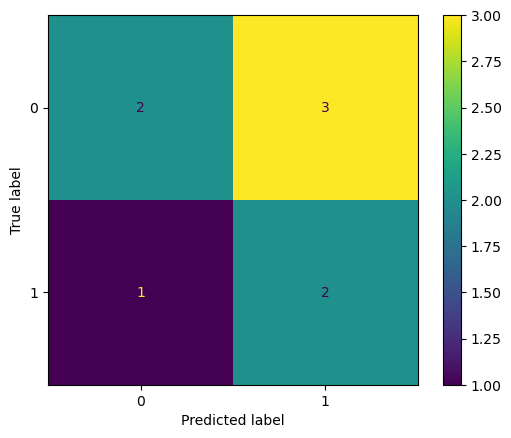

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
disp=ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()

In [10]:
precision_score(y_true, y_pred) # 정밀도

np.float64(0.4)

In [11]:
recall_score(y_true, y_pred) # 민감도

np.float64(0.6666666666666666)

In [12]:
f1_score(y_true, y_pred) # F1 스코어

np.float64(0.5)

In [13]:
2 * (precision_score(y_true, y_pred) * recall_score(y_true, y_pred)) / (precision_score(y_true, y_pred) + recall_score(y_true, y_pred))

np.float64(0.5)

## 로지스틱 회귀를 구현해 봅시다
* 사실상 선형 회귀와 거의 같습니다. 다만 "확률"을 예측하는 것만 다릅니다.

### 시그모이드, 가설함수, 비용함수
* 기본적으로는 아래의 3 함수가 필요합니다.
* Sigmoid: $h_\theta (x) = g(z) = \frac{1}{1 + exp(-z)}$

In [14]:
import numpy as np
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

* 가설 함수: 시그모이드 값의 입력을 가중치와 feature의 선형 결합으로 해 주면 됩니다

$h_\theta (x) = \frac{1}{1 + exp(-\theta^T x)}$

In [15]:
def hypothesis_function(x, theta):
    z = (np.dot(x, theta))
    return sigmoid(z)

* 비용 함수: transpose와 dot을 이용해서 두 벡터의 곱셈합 연산으로 구현합니다.

$J(\theta)=\frac{1}{m}\sum_{i=1}^m Cost(h_\theta(x^i), y^i)$

$=\frac{1}{m}\sum_{i=1}^m [y^i log(h_\theta (x^i) + (1-y^i)log(1-h_\theta(x^i))]$ 



In [16]:
def compute_cost(x, y, theta):
    m = y.shape[0]
    J = (-1.0 / m) * (y.T.dot(np.log(hypothesis_function(x,theta))) 
                      + (1-y).T.dot(np.log(1- hypothesis_function(x,theta))))
    return J

### 경사하강법의 가중치 업데이트
* 선형회귀와 구현은 거의 동일합니다

$\theta_j := \theta_j - \alpha \sum^m_{i=1} (h_\theta (x^i)-y^i))x^i_j$

In [17]:
def minimize_gradient(x, y, theta, iterations=100000, alpha=0.01):
    m = y.size
    cost_history = []
    theta_history = []
 
    for _ in range(iterations):
        original_theta = theta
        for i in range(theta.size):
            partial_marginal = x[:, i].reshape(x.shape[0], 1)
            delta = hypothesis_function(x, original_theta) - y
            grad_i = delta.T.dot(partial_marginal)
            print(theta[i] - (alpha * grad_i))
            theta[i] = theta[i] - (alpha * grad_i)
 
        if (_ % 100) == 0:
            theta_history.append(theta)
            cost_history.append(compute_cost(x, y, theta))
    return theta, np.array(cost_history),np.array(theta_history)

## Scikit-learn을 통한 학습

```sklearn.linear_model.LogisticRegression``` 을 사용하면 됩니다

### 데이터 수집
* 여기서는 인터넷 사용자가 뉴비(newbie: 어떤 일을 처음 하는 사람)인지 판별하는 데이터인 Wharton School uva 데이터를 씁니다.

In [18]:
import pandas as pd
data_url= "http://www-stat.wharton.upenn.edu/~waterman/DataSets/uva.txt"

df = pd.read_table(data_url)
df[:5]

,who,Newbie,Age,Gender,Household Income,Sexual Preference,Country,Education Attainment,Major Occupation,Marital Status,Years on Internet
0,id74364,0,54.0,Male,$50-74,Gay male,Ontario,Some College,Computer,Other,4-6 yr
1,id84505,0,39.0,Female,Over $100,Heterosexual,Sweden,Professional,Other,Other,1-3 yr
2,id84509,1,49.0,Female,$40-49,Heterosexual,Washington,Some College,Management,Other,Under 6 mo
3,id87028,1,22.0,Female,$40-49,Heterosexual,Florida,Some College,Computer,Married,6-12 mo
4,id76087,0,20.0,Male,$30-39,Bisexual,New Jersey,Some College,Education,Single,1-3 yr


### 전처리
*  일단 쓸모 없거나(who) 정답을 직접 알려주거나(Years on Internet), 정보가 너무 많고 다루기 힘든 것(Country; 거주국가/주 정보)을 지워봅시다.  

In [19]:
df.pop('who')
df.pop('Country')
df.pop('Years on Internet')

df.dtypes

Newbie                    int64
Age                     float64
Gender                   object
Household Income         object
Sexual Preference        object
Education Attainment     object
Major Occupation         object
Marital Status           object
dtype: object

* 카테고리 데이터는 one-hot-encoding으로 바꾸기 위해 카테고리 데이터형으로 변환시킵니다. 

In [20]:
category_cols = ["Gender", 'Household Income',
                 'Sexual Preference', 'Education Attainment',
                 'Major Occupation', "Marital Status"]

for col in category_cols:
    df[col] = df[col].astype('category')
    
df.dtypes

Newbie                     int64
Age                      float64
Gender                  category
Household Income        category
Sexual Preference       category
Education Attainment    category
Major Occupation        category
Marital Status          category
dtype: object

* 범주화 시켜봅니다


In [21]:
df_onehot = pd.get_dummies(df)
df_onehot.shape

(19583, 38)

* 결측치를 봅시다.

In [22]:
df_onehot.isnull().sum()

Newbie                                 0
Age                                  561
Gender_Female                          0
Gender_Male                            0
Household Income_$10-19                0
Household Income_$20-29                0
Household Income_$30-39                0
Household Income_$40-49                0
Household Income_$50-74                0
Household Income_$75-99                0
Household Income_Over $100             0
Household Income_Under $10             0
Sexual Preference_Bisexual             0
Sexual Preference_Gay male             0
Sexual Preference_Heterosexual         0
Sexual Preference_Lesbian              0
Sexual Preference_Transgender          0
Sexual Preference_na                   0
Education Attainment_College           0
Education Attainment_Doctoral          0
Education Attainment_Grammar           0
Education Attainment_High School       0
Education Attainment_Masters           0
Education Attainment_Other             0
Education Attain

* 나이에는 결측치가 많습니다. 이를 해결하기위해 그냥 "평균 나이"로 채워봅시다.

In [23]:
df_onehot.loc[pd.isnull(df_onehot['Age']), "Age"] = df_onehot['Age'].mean()

### 데이터 분리
* x와 y데이터를 분리합시다

In [24]:
x_data = df_onehot.iloc[:, 1:].values
y_data = df_onehot.iloc[:, 0].values.reshape(-1, 1)
y_data.shape, x_data.shape

((19583, 1), (19583, 37))

* 데이터 값의 차이가 큰 것들의 영향을 제거하기 위해 min-max scaling을 합니다

In [25]:
from sklearn import preprocessing # Min-Max Standardzation

min_max_scaler = preprocessing.MinMaxScaler()
x_data = min_max_scaler.fit_transform(x_data)

* 데이터를 학습과 테스트 데이터로 나눕니다.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.33, random_state=42)

X_train.shape, X_test.shape

((13120, 37), (6463, 37))

### 이제 학습을 해 봅시다. 
* sklearn의 모델로 학습을 하고

In [27]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=True)
logreg.fit(X_train, y_train.flatten())

LogisticRegression()

In [28]:
y_train.reshape(-1)

array([0, 0, 1, ..., 1, 0, 1])

In [29]:
LogisticRegression(C=1.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='warn',
                   n_jobs=None, penalty='l2', random_state=None,
                   solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(multi_class='warn', solver='warn')

* y 값을 예측해 봅시다.
* ```predict``` 함수는 단순히 y = 0 혹은 1을 예측합니다.

In [30]:
logreg.predict(X_test[:5])

array([0, 0, 0, 0, 0])

* 원래logistic regression은 확률을 예측해 줍니다.  
* 예측값에 대한 확률을 구하려면 ```predict_proba``` 함수를 써주면 됩니다.

In [31]:
logreg.predict_proba(X_test[:5])

array([[0.56804624, 0.43195376],
       [0.91113996, 0.08886004],
       [0.79499294, 0.20500706],
       [0.85913521, 0.14086479],
       [0.62787685, 0.37212315]])

In [32]:
# Test Metric을 봅시다
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_true = y_test.copy()
y_pred = logreg.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[4488,  274],
       [1351,  350]])

In [33]:
accuracy_score(y_true, y_pred)

0.7485687761101656

* 정답의 y값 분포는 어떻게 될까요? 

In [34]:
print(sum(y_true.reshape(-1)), len(y_true.reshape(-1))-sum(y_true.reshape(-1)))

1701 4762


* 약간 불균형 합니다. 
* Precision, Recall 등을 봅시다

In [35]:
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("precision:", precision_score(y_true, y_pred))
print("recall:", recall_score(y_true, y_pred))
print("f1:", f1_score(y_true, y_pred))

# Recall이 낮은 것을 볼 수 있습니다.

precision: 0.5608974358974359
recall: 0.205761316872428
f1: 0.3010752688172043


In [36]:
print(sum(y_pred), len(y_true))

624 6463
